In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [10]:
df = pd.read_csv('ETH-USD.csv')
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)

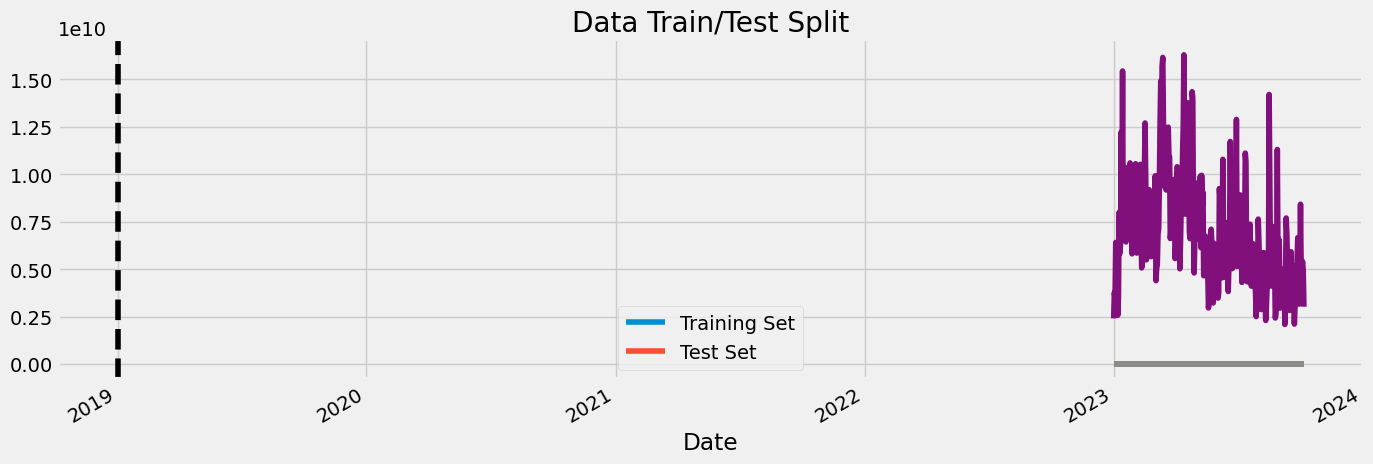

In [11]:
train = df.loc[df.index < '01-01-2019']
test = df.loc[df.index >= '01-01-2023']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2019', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

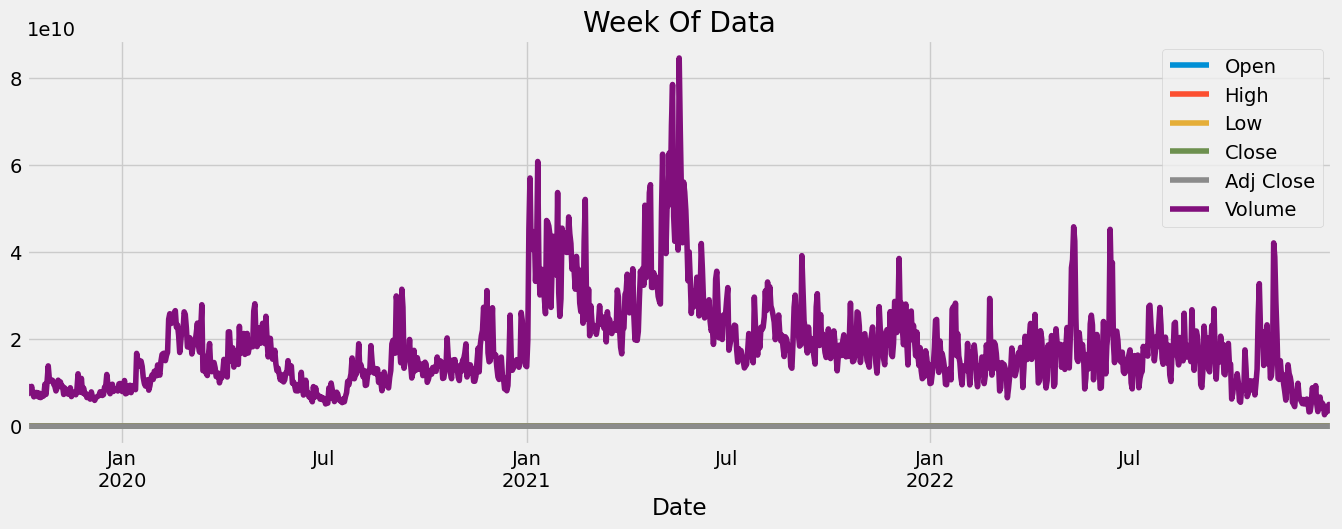

In [12]:
df.loc[(df.index > '01-01-2018') & (df.index < '01-01-2023')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [13]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)